# Notebook for Colab

In [ ]:
import numpy as np
np.zeros((3,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [2]:
import random
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQNetwork(nn.Module):

    def __init__(self, n_actions: int=4, n_observations: int=8, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.out_layer = nn.Linear(128, n_actions)

    def forward(self, inputs):
        """
        Forward pass through network
        """
        x = F.relu(self.layer1(inputs))
        x = F.relu(self.layer2(x))
        out = self.out_layer(x)
        return out

In [13]:
# Copyright [2024] [KTH Royal Institute of Technology]
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 2 for EL2805 - Reinforcement Learning.


# Load packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

class Agent(object):
    ''' Base agent class, used as a parent class

        Args:
            n_actions (int): number of actions

        Attributes:
            n_actions (int): where we store the number of actions
            last_action (int): last action taken by the agent
    '''
    def __init__(self, n_actions: int):
        self.n_actions = n_actions
        self.last_action = None

    def forward(self, state: np.ndarray):
        ''' Performs a forward computation '''
        pass

    def backward(self):
        ''' Performs a backward pass on the network '''
        pass


class RandomAgent(Agent):
    ''' Agent taking actions uniformly at random, child of the class Agent'''
    def __init__(self, n_actions: int):
        super(RandomAgent, self).__init__(n_actions)

    def forward(self, state: np.ndarray) -> int:
        ''' Compute an action uniformly at random across n_actions possible
            choices

            Returns:
                action (int): the random action
        '''
        self.last_action = np.random.randint(0, self.n_actions)
        return self.last_action


class DQNAgent(Agent):
    def __init__(self, n_actions, n_observations, capacity=5000, epsilon_max=0.99, epsilon_min=0.01,
                 batch_size=32, gamma=0.99, learning_rate=0.001):
        super().__init__(n_actions)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net = DQNetwork(n_actions, n_observations).to(device)
        self.target_net = DQNetwork(n_actions, n_observations).to(device)
        self.replay_buffer = ReplayMemory(capacity=capacity)
        self.training_mode = True
        self.epsilon = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters(), learning_rate)

    def forward(self, state):
        """
        Select an action epsilon-greedily (in training mode)
        """
        if self.training_mode:
            if random.random() < self.epsilon:
                return torch.tensor([[random.randint(0, self.n_actions-1)]], device=self.device)
        return self.policy_net(state).max(1).indices.view(1,1)

    def backward(self):
        """
        Perform an optimization step, samples transitions from the replay buffer
        and updates the
        """
        if len(self.replay_buffer) < self.batch_size:
            return

        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=self.device,
            dtype=torch.bool
        )
        non_final_next_states = torch.cat(
            [s for s in batch.next_state if not s is None]
        )
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(size=(self.batch_size,), device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        y = (reward_batch + self.gamma * next_state_values)
        loss = self.loss_fn(state_action_values, y.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

    def memorize(self, state, action, next_state, reward):
        """
        Pushes a transition to the agents replay buffer
        """
        self.replay_buffer.push(state, action, next_state, reward)

    def update_target_net(self):
        """
        Update target net parameters to policy net parameters
        """
        policy_net_state_dict = self.policy_net.state_dict()
        self.target_net.load_state_dict(policy_net_state_dict)

    def update_epsilon(self, k, N):
        """
        Updates epsilon (in epsilon-greedy) with exponential decay
        Params:
            k (int): current episode
            N (int): total number of training episodes
        """
        Z = 0.95*N
        self.epsilon = max(
            self.epsilon_min,
            self.epsilon_max*(self.epsilon_min/self.epsilon_max)**((k-1)/(Z-1))
        )

    def set_training_mode(self, mode):
        """
        Set training mode True = Training, False = Inference
        """
        self.training_mode = mode

    def save_model_weights(self, path):
        """
        Saves the model to path
        """
        torch.save(self.policy_net.state_dict(), path)

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


Episode 399 - Reward/Steps: 258.8/213 - Avg. Reward/Steps: 266.4/303: 100%|██████████| 400/400 [12:15<00:00,  1.84s/it]


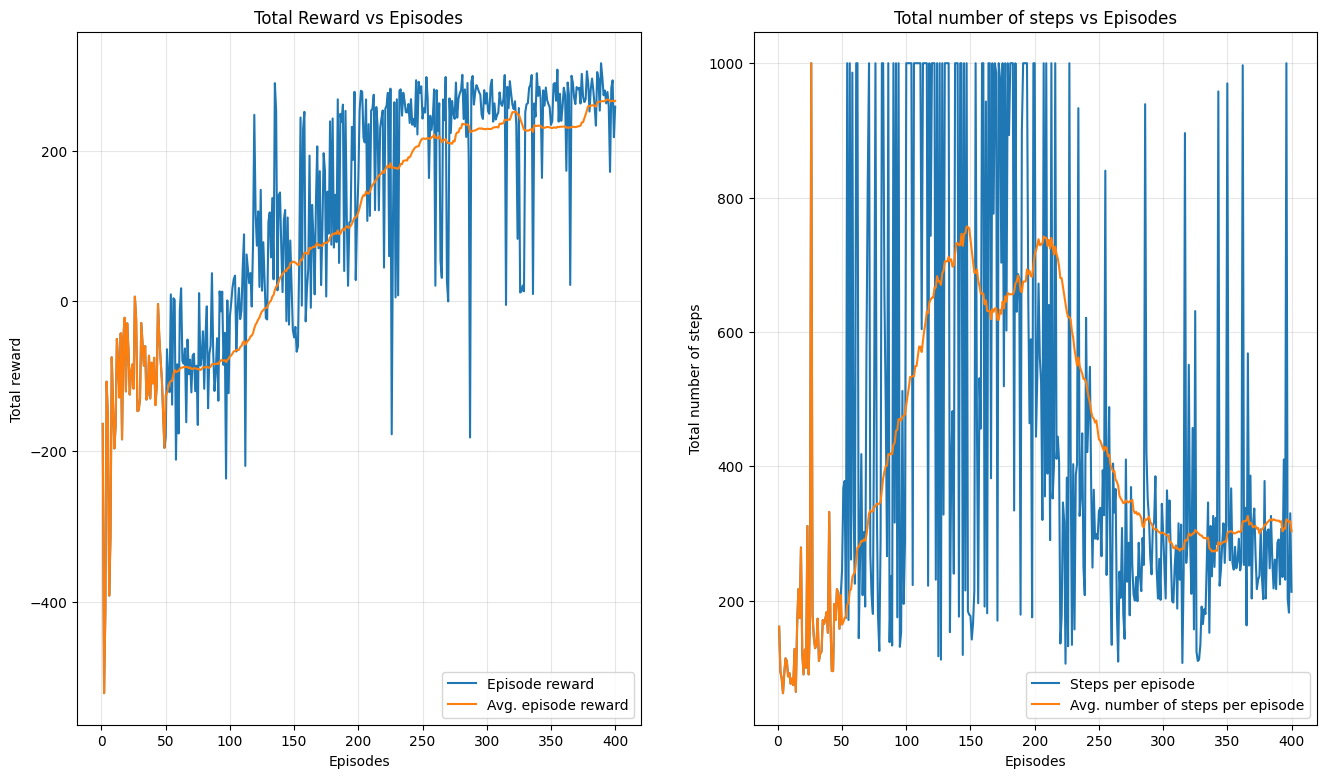

In [16]:
# Copyright [2024] [KTH Royal Institute of Technology]
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 2 for EL2805 - Reinforcement Learning.

# Load packages

!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]

from google.colab import drive
drive.mount('gdrive')

import numpy as np
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
from tqdm import trange
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

# Import and initialize the discrete Lunar Lander Environment
env = gym.make('LunarLander-v3')
# If you want to render the environment while training run instead:
# env = gym.make('LunarLander-v2', render_mode = "human")


env.reset()

# Parameters
N_episodes = 400                             # Number of episodes
discount_factor = 0.995                      # Value of the discount factor
n_ep_running_average = 50                    # Running average of 50 episodes
n_actions = env.action_space.n               # Number of available actions
dim_state = len(env.observation_space.high)  # State dimensionality
capacity = 20000
target_net_update_freq = int(capacity/N_episodes)
agent_cfg = {
    'n_actions': n_actions,
    'n_observations': dim_state,
    'capacity': capacity,
    'epsilon_max': 0.7,
    'epsilon_min': 0.05,
    'batch_size': 256,
    'gamma': discount_factor,
    'learning_rate': 0.0001
}

# We will use these variables to compute the average episodic reward and
# the average number of steps per episode
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = []   # this list contains the number of steps per episode

# Random agent initialization
# agent = RandomAgent(n_actions)
agent = DQNAgent(**agent_cfg)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
### Training process

# trange is an alternative to range in python, from the tqdm library
# It shows a nice progression bar that you can update with useful information
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
step = 0
best_avg_return = float('-inf')
for i in EPISODES:
    # Reset enviroment data and initialize variables
    done, truncated = False, False
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_episode_reward = 0.
    t = 0
    while not (done or truncated):
        # Take a random action
        action = agent.forward(state)

        # Get next state and reward
        next_state, reward, done, truncated, _ = env.step(action.item())
        total_episode_reward += reward
        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        if done:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        # Remember transition in replay buffer
        agent.memorize(state, action, next_state, reward)

        # Update state for next iteration
        state = next_state

        # Optimize model
        agent.backward()

        # Update target net
        if step % target_net_update_freq == 0 and t != 0:
            agent.update_target_net()

        t+= 1
        step+=1

    agent.update_epsilon(i, N_episodes)

    # Append episode reward and total number of steps
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)
    if len(episode_reward_list) >= 50:
        avg_return = sum(episode_reward_list[-50:]) / 50
        if avg_return > 10 and avg_return > best_avg_return:
            best_avg_return = avg_return
            agent.save_model_weights(f"best_model_{step}.pt")

    # Updates the tqdm update bar with fresh information
    # (episode number, total reward of the last episode, total number of Steps
    # of the last episode, average reward, average number of steps)
    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))

# Close environment
env.close()

# Plot Rewards and steps
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()
